# Wynn Resort Forecast Model Tutorial
## Part 2: Building the RNN Forecast Model

This notebook demonstrates the forecasting engine that will power our AI system.

In [2]:
# # Install required packages
# !pip install numpy pandas matplotlib

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import json

## Step 1: Generate Historical Data
Creating realistic Vegas hotel patterns with hourly granularity

In [4]:
def generate_historical_data():
    """Generate 6 months of hourly Vegas hotel data"""
    
    # Generate hourly data from 6 months ago to now
    start_date = datetime.now() - timedelta(days=180)
    end_date = datetime.now()
    
    dates = []
    current_date = start_date
    while current_date <= end_date:
        dates.append(current_date)
        current_date += timedelta(hours=1)
    
    data = []
    for date in dates:
        hour = date.hour
        day_of_week = date.weekday()
        
        # Base patterns
        # Room occupancy: Higher on weekends, peaks at night
        if day_of_week >= 4:  # Friday-Sunday
            room_base = 85 + 10 * np.sin(2 * np.pi * hour / 24)
        else:
            room_base = 70 + 15 * np.sin(2 * np.pi * hour / 24)
        
        # Cleaning staff: Peaks during checkout (10-14) and turndown (18-20)
        if 10 <= hour <= 14:
            cleaning_base = 80 + (room_base * 0.8)
        elif 18 <= hour <= 20:
            cleaning_base = 40 + (room_base * 0.3)
        else:
            cleaning_base = 20 + (room_base * 0.1)
        
        # Security: Higher at night, especially weekends
        if 22 <= hour or hour <= 4:
            security_base = 40 + (20 if day_of_week >= 4 else 10)
        else:
            security_base = 20 + (10 if day_of_week >= 4 else 5)
        
        # Add noise
        rooms = max(0, min(100, room_base + np.random.normal(0, 5)))
        cleaning = max(0, cleaning_base + np.random.normal(0, 10))
        security = max(0, security_base + np.random.normal(0, 5))
        
        data.append({
            'datetime': date,
            'rooms': rooms,
            'cleaning': cleaning,
            'security': security
        })
    
    return pd.DataFrame(data)

# Generate the data
historical_data = generate_historical_data()
print(f"Generated {len(historical_data)} hours of historical data")
print(f"Date range: {historical_data['datetime'].min()} to {historical_data['datetime'].max()}")
historical_data.tail()

Generated 4321 hours of historical data
Date range: 2024-12-22 20:41:05.284949 to 2025-06-20 20:41:05.284949


,datetime,rooms,cleaning,security
4316,2025-06-20 16:41:05.284949,60.461269,27.901055,27.851902
4317,2025-06-20 17:41:05.284949,73.741412,33.854520,28.946727
4318,2025-06-20 18:41:05.284949,74.429358,66.340965,33.413896
4319,2025-06-20 19:41:05.284949,72.345272,64.639314,31.382373
4320,2025-06-20 20:41:05.284949,67.449945,71.256633,26.755909


## Step 2: Build the Forecast Model

In [ ]:
# class ForecastRNN:
#     def __init__(self):
#         self.metrics = ['rooms', 'cleaning', 'security']
#         self.model_trained = False
#         self.base_patterns = {}
    
#     def train(self, historical_data):
#         """Train model by analyzing historical patterns"""
#         for metric in self.metrics:
#             # Calculate hourly averages
#             hourly_avg = historical_data.groupby(historical_data['datetime'].dt.hour)[metric].mean()
            
#             # Calculate day of week patterns
#             dow_avg = historical_data.groupby(historical_data['datetime'].dt.dayofweek)[metric].mean()
            
#             # Store patterns
#             self.base_patterns[metric] = {
#                 'hourly': hourly_avg.to_dict(),
#                 'dow': dow_avg.to_dict(),
#                 'overall_mean': historical_data[metric].mean(),
#                 'overall_std': historical_data[metric].std()
#             }
        
#         self.model_trained = True
#         print("Model training complete!")
    
#     def predict(self, historical_data, hours=168):
#         """Generate hourly forecast for next 168 hours (7 days)"""
#         if not self.model_trained:
#             self.train(historical_data)
        
#         forecast_data = []
#         start_time = datetime.now()
        
#         for i in range(hours):
#             forecast_time = start_time + timedelta(hours=i+1)
#             hour = forecast_time.hour
#             dow = forecast_time.weekday()
            
#             row = {'datetime': forecast_time}
            
#             for metric in self.metrics:
#                 # Combine hourly and day-of-week patterns
#                 hourly_factor = self.base_patterns[metric]['hourly'][hour]
#                 dow_factor = self.base_patterns[metric]['dow'][dow]
#                 base_value = (hourly_factor + dow_factor) / 2
                
#                 # Add some random variation
#                 noise = np.random.normal(0, self.base_patterns[metric]['overall_std'] * 0.1)
#                 value = base_value + noise
                
#                 # Ensure reasonable bounds
#                 if metric == 'rooms':
#                     value = max(50, min(100, value))
#                 else:
#                     value = max(0, value)
                
#                 row[metric] = value
            
#             forecast_data.append(row)
        
#         return pd.DataFrame(forecast_data)

# # Create and train the model
# model = ForecastRNN()
# model.train(historical_data)

Model training complete!


## Step 3: Generate Forecast

In [6]:
# Generate 168-hour forecast
forecast = model.predict(historical_data)
print(f"Generated {len(forecast)} hours of forecast")
forecast.head()

Generated 168 hours of forecast


,datetime,rooms,cleaning,security
0,2025-06-20 21:41:05.284949,73.326400,42.254179,44.842378
1,2025-06-20 22:41:05.284949,75.043740,27.539516,52.278324
2,2025-06-20 23:41:05.284949,76.027691,16.889520,58.330680
3,2025-06-21 00:41:05.284949,83.042803,58.923904,55.647100
4,2025-06-21 01:41:05.284949,89.106915,43.912468,59.253736


## Step 4: Visualize the Forecast

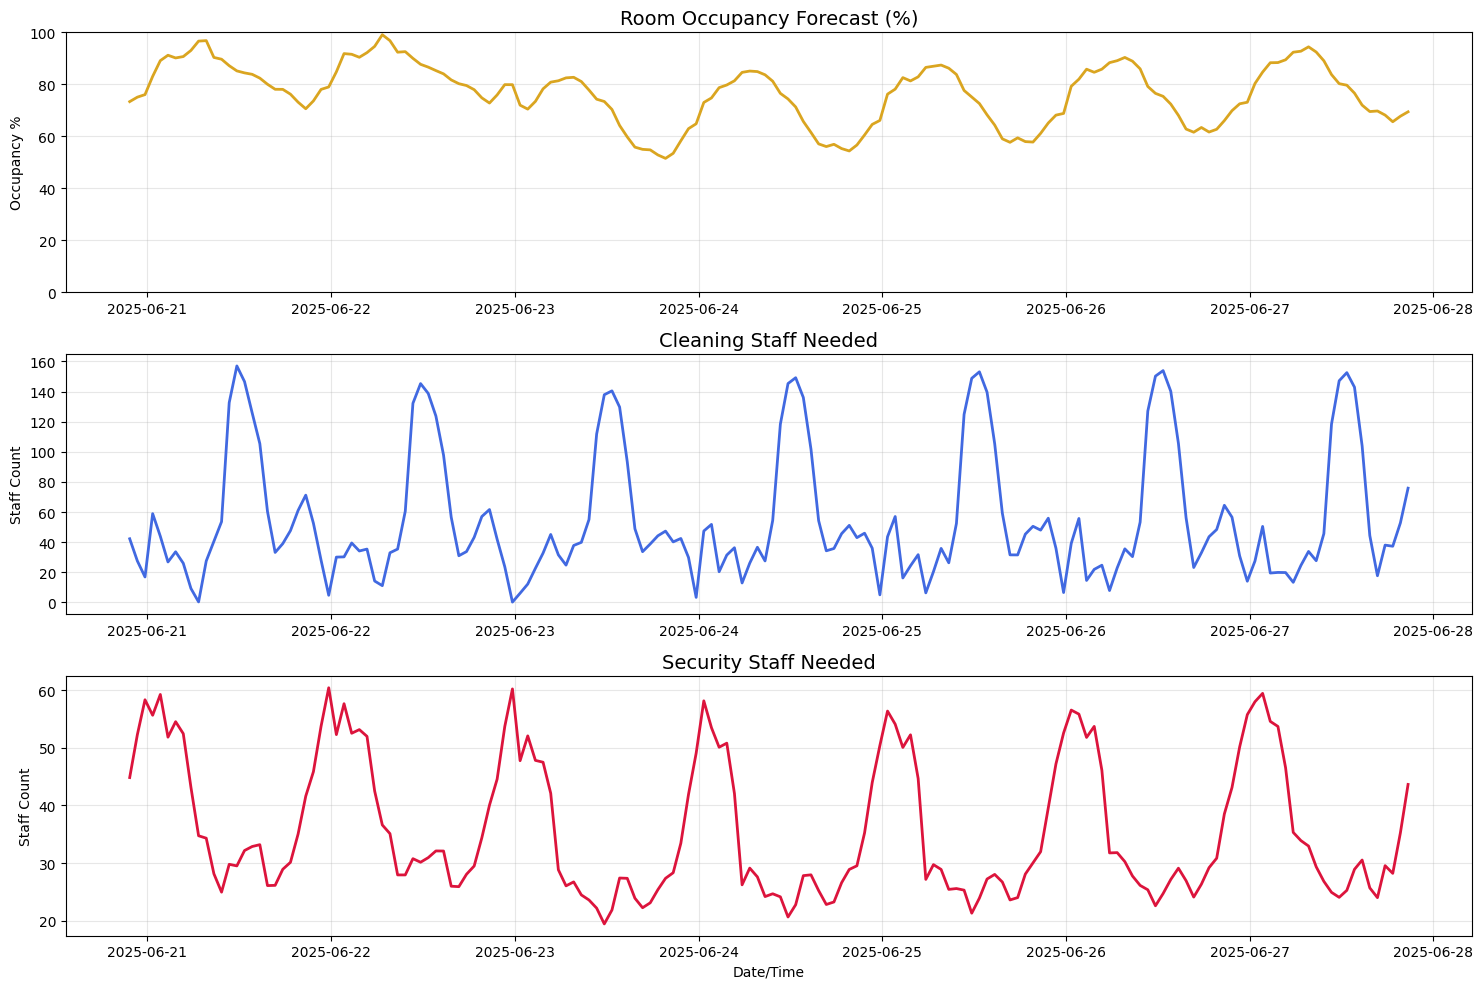

In [7]:
# Plot the forecast
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Room Occupancy
axes[0].plot(forecast['datetime'], forecast['rooms'], color='goldenrod', linewidth=2)
axes[0].set_title('Room Occupancy Forecast (%)', fontsize=14)
axes[0].set_ylabel('Occupancy %')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 100)

# Cleaning Staff
axes[1].plot(forecast['datetime'], forecast['cleaning'], color='royalblue', linewidth=2)
axes[1].set_title('Cleaning Staff Needed', fontsize=14)
axes[1].set_ylabel('Staff Count')
axes[1].grid(True, alpha=0.3)

# Security Staff
axes[2].plot(forecast['datetime'], forecast['security'], color='crimson', linewidth=2)
axes[2].set_title('Security Staff Needed', fontsize=14)
axes[2].set_ylabel('Staff Count')
axes[2].set_xlabel('Date/Time')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 5: Export Forecast for Frontend

In [7]:
# Convert to format matching our frontend
def prepare_for_frontend(historical_df, forecast_df):
    """Prepare data in the format expected by frontend"""
    
    # Get last 168 hours of historical data
    historical_recent = historical_df.tail(168).copy()
    
    # Convert datetime to string
    historical_recent['date'] = historical_recent['datetime'].dt.strftime('%Y-%m-%d %H:%M')
    forecast_df['date'] = forecast_df['datetime'].dt.strftime('%Y-%m-%d %H:%M')
    
    # Select only needed columns
    historical_export = historical_recent[['date', 'rooms', 'cleaning', 'security']].to_dict('records')
    forecast_export = forecast_df[['date', 'rooms', 'cleaning', 'security']].to_dict('records')
    
    return {
        'historical': historical_export,
        'forecast': forecast_export
    }

# Prepare the data
frontend_data = prepare_for_frontend(historical_data, forecast)

# Save to JSON file
with open('wynn_forecast_data.json', 'w') as f:
    json.dump(frontend_data, f, indent=2)

print(f"Exported {len(frontend_data['historical'])} historical records")
print(f"Exported {len(frontend_data['forecast'])} forecast records")
print("\nData saved to wynn_forecast_data.json")

Exported 168 historical records
Exported 168 forecast records

Data saved to wynn_forecast_data.json


## Summary

We've built a forecasting model that:
1. Generates realistic Vegas hotel patterns
2. Trains on historical hourly data
3. Produces 168-hour forecasts
4. Exports data for our frontend

Next steps: Connect this to our WebSocket backend!